## Solo Exploration and Presentation:

available on: https://github.com/nss-data-science-cohort-6/un_data_question-tomoumer

1. Choose and download another data set from the UN data http://data.un.org/Explorer.aspx to explore. You may want to combine your new dataset with one or both of the datasets that you already worked with. Prepare a short (< 5 minute) presentation of your findings. Report any interesting correlations or trends that you find.

2. If time allows, check out the plotly library to add additional interativity to your plots. https://plotly.com/python/plotly-express/.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gdp_df = pd.read_csv('../data/gdp_per_capita.csv', skipfooter=2, engine='python')

In [3]:
gdp_df = (gdp_df
    .drop(columns='Value Footnotes')
    .rename(columns={'Country or Area': 'Country', 'Value': 'GDP_Per_Capita'})
    ) 

In [5]:
trade = pd.read_csv('../data/tradeofgoods.csv')

In [6]:
trade = (
    trade
    .rename(columns = {'Country or Area' : 'Country'})
    .drop(columns = ['Commodity', 'Weight (kg)', 'Quantity Name', 'Quantity'])
)
trade['Country'] = trade['Country'].str.replace('USA', 'United States')

In [7]:
gdp_trade = pd.merge(gdp_df, trade, "inner", on=['Country', 'Year'])

In [8]:
gdp_trade.loc[gdp_trade['Country'].isin(['Slovenia', 'Italy', 'United States'])]

,Country,Year,GDP_Per_Capita,Flow,Trade (USD)
3544,Italy,2018,42187.824116,Import,5.035811e+11
3545,Italy,2018,42187.824116,Export,5.499070e+11
3546,Italy,2018,42187.824116,Re-Export,2.385311e+10
3547,Italy,2018,42187.824116,Re-Import,4.986970e+09
3548,Italy,2017,41713.900017,Import,4.535830e+11
...,...,...,...,...,...
7620,United States,1992,40698.340183,Export,4.473301e+11
7621,United States,1992,40698.340183,Re-Export,2.245862e+10
7622,United States,1991,39862.575565,Import,5.089440e+11
7623,United States,1991,39862.575565,Export,4.215554e+11


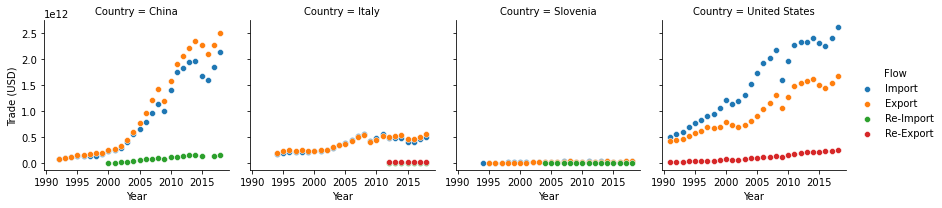

In [10]:
fg = sns.FacetGrid(
    gdp_trade.loc[gdp_trade['Country'].isin(['Slovenia', 'Italy', 'United States', 'China'])],
    col='Country',
    hue='Flow'
)
fg.map(sns.scatterplot, 'Year', 'Trade (USD)')
fg.add_legend()

Comment on above graphs: Slo's trade is ofc negligible compared to US. What's interesting though is that Italy seems to be oscillating around the same value, while the US is consistently on the rise, though the imports are outpacing the exports. China instead is exporting more than importing.